## We're going to analyze the MetaBUG project from start to finish, critically looking at:

## 1) inclusion of all relevant data, annotated correctly, 

## 2) application of relevant assumptions and stratifications, and 
## 3) correct implementation of all statistical tests. 

## All data has been processed and metadata collected, so we'll start with confirming these data all look correct. To start, we'll open a dataframe describing which studies are included in this meta-analysis. 

In [52]:
import pandas as pd
import os
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels as sm
import matplotlib.pyplot as plt
from utils import *
from matplotlib.font_manager import FontProperties


%matplotlib inline

In [4]:
collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]
disease = pd.read_csv('/proj/gibbons/nbohmann/metabug/conditions.csv',index_col = 0,header = None)[1].to_dict()
os.chdir('/proj/gibbons/nbohmann/metabug/manifest/NP/')
manifest_NP = pd.read_csv('NP_manifest.csv',index_col= 0, header = None)
res = pd.DataFrame()
for file_name in manifest_NP.index:
    #pull out feature tables with total reads
    ab = qiime_to_dataframe(feature_table="qiime/"+file_name+"_table.qza",
                        taxonomy="qiime/"+file_name+"_taxonomy.qza", 
                        collapse_on=collapse_on) 
    #merge with metadata
    meta = pd.read_csv('metadata/'+file_name+'_metadata.tsv', sep="\t")
    meta.rename(columns={meta.columns[0]: "sample_id"}, inplace=True)
    ab = pd.merge(ab, meta, on="sample_id")
    ab['URT'] = 'NP'
    ab['Study'] = file_name
    #concatenate dataframes together
    res = pd.concat([res,ab])
os.chdir('/proj/gibbons/nbohmann/metabug/manifest/OP/')
manifest_OP = pd.read_csv('OP_manifest.csv',index_col= 0, header = None)
for file_name in manifest_OP.index:
    #pull out feature tables with total reads
    ab = qiime_to_dataframe(feature_table="qiime/"+file_name+"_table.qza",
                        taxonomy="qiime/"+file_name+"_taxonomy.qza", 
                        collapse_on=collapse_on) 
    #merge with metadata
    meta = pd.read_csv('metadata/'+file_name+'_metadata.tsv', sep="\t")
    meta.rename(columns={meta.columns[0]: "sample_id"}, inplace=True)
    ab = pd.merge(ab, meta, on="sample_id")
    ab['URT'] = 'OP'
    ab['Study'] = file_name
    #concatenate dataframes together
    res = pd.concat([res,ab])
res = res.dropna(subset = ['genus']) #filter data 
res = res[~(res.genus.str.contains('None'))&~(res.genus.str.contains('uncultured'))&~(res.genus.str.contains('Chloroplast'))]
res = clr(filter_taxa(res, min_reads=2, min_prevalence=0.5)) #center-log-ratio transformation and filtering
res['disease'] = res['Study'].map(disease)
res['log10'] = np.log10(res['reads'])
res['Study'] = res['Study'].str.replace('PRJEB15534','PRJEB22676')

In [5]:
studies = pd.DataFrame(res['Study'].unique())
studies

,0
0,PRJEB14780
1,PRJEB20811
2,PRJEB22676
3,PRJEB23057
4,PRJEB28053
5,PRJNA240559
6,PRJNA275918
7,PRJNA317701
8,PRJNA428382
9,PRJNA431097


In [54]:
res.sample_id.nunique()

4701

/tmp/ipykernel_4128122/415472920.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


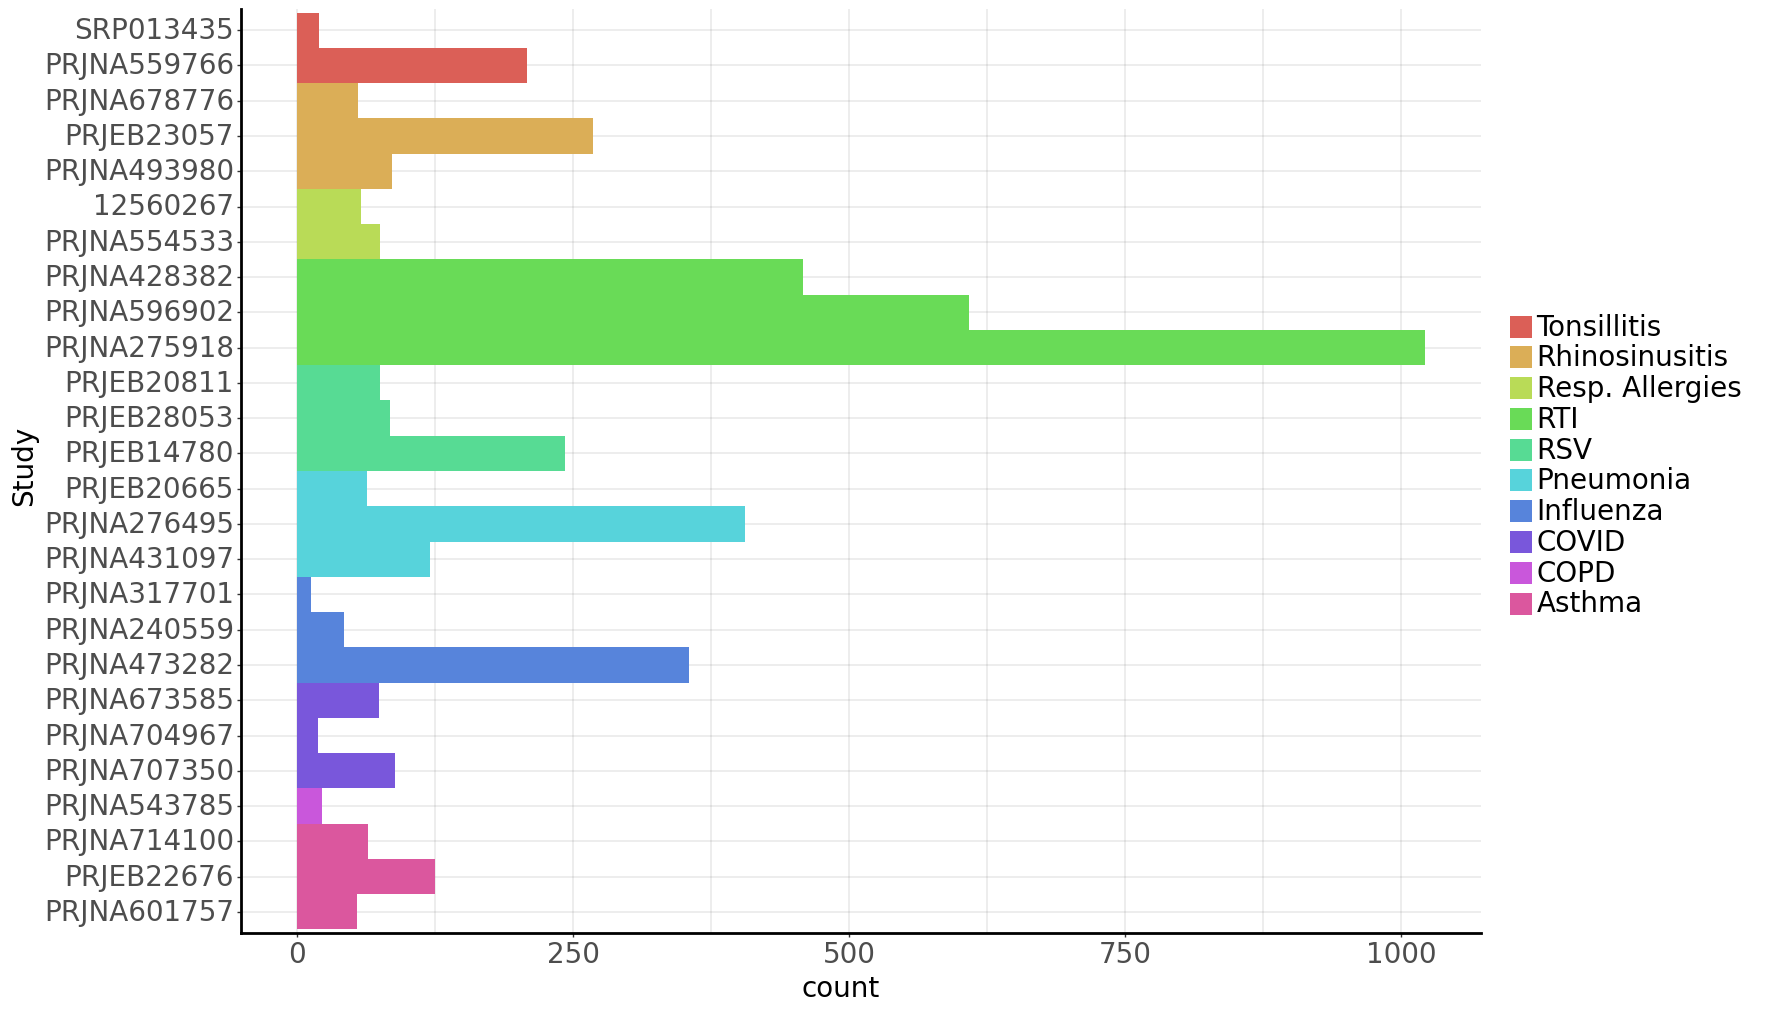

<ggplot: (8738340128759)>

In [6]:
res_grouped = res.groupby(['sample_id','Study','disease']).mean().reset_index()
res_grouped = res_grouped.sort_values(by = 'disease')
yscale = res_grouped['Study'].unique()
fillscale = res_grouped['disease'].unique()[::-1]
sample_plot = (ggplot(
    res_grouped, aes(x = 'Study',fill = 'disease'))
    +geom_histogram(bins = 26)
    +scale_x_discrete(limits = yscale)
    +scale_fill_discrete(limits = fillscale)
    +coord_flip()
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),
                                panel_grid=element_line(size = .2, linetype = "solid",colour = "gray"),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_title=element_blank(),
                                legend_position='right',
                                figure_size=(16, 12))
              )
sample_plot

In [7]:
overall = pd.DataFrame()
for x in res['full_taxonomy'].unique():
    try:
        df = res[res['full_taxonomy']==x]
        df = df.copy()
        df['condition_bin'] = (df['condition'] == 'control').astype(int)
        model = smf.logit('condition_bin ~ clr + URT+ region', data = df)
        sol = model.fit(method='bfgs', disp=0)
        log2 = np.log2(df[df['condition']=='case']['relative'].mean()/
                       df[df['condition']=='control']['relative'].mean())
        overall = pd.concat([overall,
                             pd.DataFrame({
                                 'taxon':[x], 
                                 'pvalue':[sol.pvalues['clr']],
                                 'log2_foldchange':[log2]})])
    except sm.tools.sm_exceptions.PerfectSeparationError:
            print("Skipping group", x, "due to perfect predictor error")
            continue
    
overall['q'] = sm.stats.multitest.fdrcorrection(overall['pvalue'])[1]
overall = overall[overall['q']<0.05].sort_values(by = 'log2_foldchange')
overall['genus'] = overall['taxon'].str.split('|').str[-1]
overall['enrichment'] = overall['log2_foldchange']>0
overall['enrichment'] = overall['enrichment'].map({True:1,False:-1})
overall.set_index('genus',inplace = True)

/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/users/nbohmann/miniconda3/envs/qii

In [8]:
overall

,taxon,pvalue,log2_foldchange,q,enrichment
genus,,,,,
Dolosigranulum,Bacteria|Firmicutes|Bacilli|Lactobacillales|Ca...,2.178549e-07,-0.774981,8.706650e-07,-1
Fusobacterium,Bacteria|Fusobacteriota|Fusobacteriia|Fusobact...,1.057129e-02,-0.594302,1.996799e-02,-1
Corynebacterium,Bacteria|Actinobacteriota|Actinobacteria|Coryn...,2.560780e-07,-0.480838,8.706650e-07,-1
Alloprevotella,Bacteria|Bacteroidota|Bacteroidia|Bacteroidale...,9.897677e-04,-0.198689,2.403722e-03,-1
Prevotella,Bacteria|Bacteroidota|Bacteroidia|Bacteroidale...,7.997100e-03,-0.122204,1.699384e-02,-1
Streptococcus,Bacteria|Firmicutes|Bacilli|Lactobacillales|St...,7.765593e-16,0.131894,1.320151e-14,1
Pseudomonas,Bacteria|Proteobacteria|Gammaproteobacteria|Ps...,1.490830e-07,0.746991,8.448038e-07,1
Haemophilus,Bacteria|Proteobacteria|Gammaproteobacteria|Pa...,7.858641e-12,0.864710,6.679845e-11,1
Acinetobacter,Bacteria|Proteobacteria|Gammaproteobacteria|Ps...,1.201767e-05,1.195738,3.405006e-05,1


In [9]:
disease_specific = pd.DataFrame()
for disease in res['disease'].unique():
    res_sub = res[res['disease']==disease]
    for x in res_sub['full_taxonomy'].unique():
        try:
            df = res_sub[res_sub['full_taxonomy']==x]
            df = df.copy()
            df['condition_bin'] = (df['condition'] == 'control').astype(int)
            if df['condition_bin'].nunique()==1:
                continue
            model = smf.logit('condition_bin ~ clr + URT', data = df)        
            sol = model.fit(disp=0)
            log2 = np.log2(df[df['condition']=='case']['relative'].mean()/
                   df[df['condition']=='control']['relative'].mean())
            disease_specific = pd.concat([disease_specific, pd.DataFrame({
                'taxon':[x], 
                'pvalue':[sol.pvalues['clr']], 
                'log2_foldchange':[log2], 
                'disease':disease})])
        except sm.tools.sm_exceptions.PerfectSeparationError:
            print("Skipping group", x,"in", disease, "due to perfect predictor error")
            continue
disease_specific['q'] = sm.stats.multitest.fdrcorrection(disease_specific['pvalue'])[1]
disease_specific = disease_specific[disease_specific['q']<0.05].sort_values(by = 'q')
disease_specific['genus'] = disease_specific['taxon'].str.split('|').str[-1]
disease_specific['enrichment'] = disease_specific['log2_foldchange']>0
disease_specific['enrichment'] = disease_specific['enrichment'].map({True:1,False:-1})
disease_specific = disease_specific.pivot(index = 'genus',columns = 'disease',values = 'enrichment')

/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/users/nbohmann/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Skipping group Bacteria|Firmicutes|Bacilli|Lactobacillales|Carnobacteriaceae|Dolosigranulum in COPD due to perfect predictor error
Skipping group Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas in Tonsillitis due to perfect predictor error


In [10]:
hits = pd.concat([disease_specific, overall[['enrichment']]],axis = 1).rename(columns = {'enrichment':'Overall'})
hits = hits.fillna(0.0)
n = res.sample_id.nunique()
prevalence = res[res.reads > 0].full_taxonomy.value_counts() / n
abundance = res[res.reads > 0].groupby('full_taxonomy')['relative'].mean()
prevalence.index = prevalence.index.str.split('|').str[-1]
abundance.index = abundance.index.str.split('|').str[-1]
prevalence = prevalence[prevalence.index.isin(hits.index)].to_dict()
abundance = abundance[abundance.index.isin(hits.index)].to_dict()
hits['prevalence'] = hits.index.map(prevalence)
hits['abundance'] = hits.index.map(abundance)
hits = hits.sort_values(by = 'abundance', ascending = False)
hits

,COPD,Influenza,Pneumonia,RSV,RTI,Resp. Allergies,Rhinosinusitis,Tonsillitis,Overall,prevalence,abundance
genus,,,,,,,,,,,
Streptococcus,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.986811,0.172154
Corynebacterium,0.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.864497,0.089547
Staphylococcus,0.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.749202,0.089240
Dolosigranulum,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.589874,0.075616
Haemophilus,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.840034,0.071028
Prevotella,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,1.0,-1.0,0.806850,0.067340
Veillonella,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.846628,0.044856
Neisseria,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.753882,0.038898
Fusobacterium,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.651138,0.023957


<AxesSubplot:xlabel='genus', ylabel='abundance'>

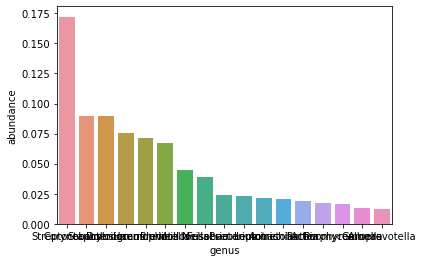

In [11]:
sns.barplot(x=hits.index,
            y=hits['abundance'])

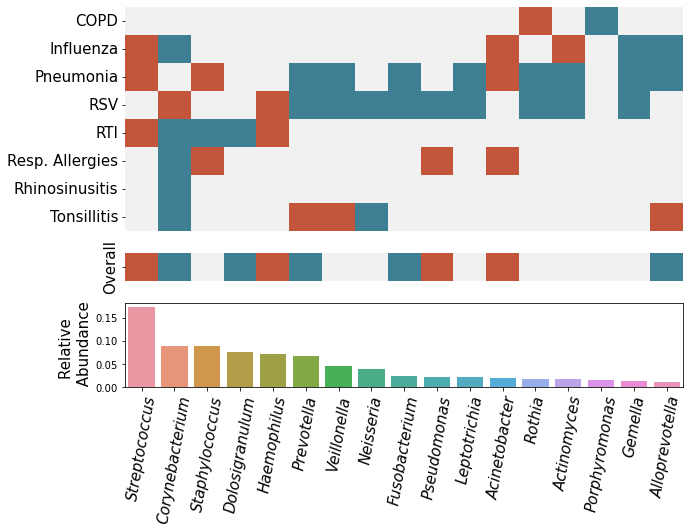

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,
                               figsize=(10, 7),
                               gridspec_kw={'height_ratios': [8,1,3]})



sns.heatmap(hits[['COPD','Influenza','Pneumonia','RSV','RTI',
                          'Resp. Allergies','Rhinosinusitis','Tonsillitis']].T,
                    cmap=sns.diverging_palette(220,20,center='light',as_cmap=True),
                    cbar = False,
                    ax = ax1)
sns.heatmap(hits[['Overall']].T,
                    cmap=sns.diverging_palette(220,20,center='light',as_cmap=True),
                    cbar = False,
                    ax = ax2)

sns.barplot(x=hits.index,
            y=hits['abundance'],
            ax=ax3)


font_props = FontProperties().copy()
font_props.set_size(15)

ax1.set_xticks([])
ax1.set(xlabel=None)
ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontproperties=font_props)

ax2.set_xticks([])
ax2.set(xlabel=None)
ax2.set_yticklabels(ax2.get_ymajorticklabels(), fontproperties=font_props)


font_props.set_style("italic")
ax3.set_ylabel('Relative \n Abundance', fontsize = 15)
ax3.set(xlabel=None)
plt.xticks(rotation =80)
ax3.set_xticklabels(ax3.get_xmajorticklabels(), fontproperties=font_props)

plt.show()

In [ ]:
n = res.sample_id.nunique()
prevalence = res[res.reads > 0].full_taxonomy.value_counts() / n
abundance = res[res.reads > 0].groupby('full_taxonomy')['relative'].mean()
prevalence.index = prevalence.index.str.split('|').str[-1]
abundance.index = abundance.index.str.split('|').str[-1]
prevalence = prevalence[prevalence.index.isin(hits.index)].to_dict()
abundance = abundance[abundance.index.isin(hits.index)].to_dict()
hits['prevalence'] = hits.index.map(prevalence)
hits['abundance'] = hits.index.map(abundance)
hits['abundance'] = np.log10(hits['abundance'])
hits

In [31]:
res[res['genus']=='Streptococcus']['relative'].sem()

0.003206250398327995

In [ ]:
hits['Overall'] = hits['Overall'].astype('str').str.replace('-1.0','Disease').str.replace('1.0','Health').str.replace('0.0','None')
order = hits.sort_values('abundance')['genus']
# hits = hits.reset_index()
abundance_plt = (ggplot(
    hits, aes(x = 'genus', y = 'abundance'))
    +geom_point()
    +labs(x = 'Genus', y = '$Log_{10}(Abundance)$')
    +scale_x_discrete(limits = order)
    +theme_minimal()
    +theme(text=element_text(size=12))
               )
abundance_plt

In [ ]:
abundance_plt = (ggplot(
    hits, aes(x = 'Overall', y = 'prevalence'))
    +geom_boxplot()
    +geom_jitter(width = 0.1)
    +labs(x = None, y = 'Prevalence')
    +theme_minimal()
    +theme(text=element_text(size=12))
               )
abundance_plt

In [ ]:
disease = pd.read_csv('/proj/gibbons/nbohmann/metabug/conditions.csv',index_col = 0,header = None)
disease

In [51]:
res[(res.condition =='case')&(res['genus']=='Fusobacterium')].relative.mean()

0.018974165442216466

In [45]:
res

,sample_id,full_taxonomy,reads,kingdom,phylum,class,order,family,genus,relative,condition,region,country,URT,Study,age,sex,clr,disease,log10
0,ERR1529161,Bacteria|Firmicutes|Bacilli|Lactobacillales|St...,33719.0,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,0.543119,control,Europe,France,NP,PRJEB14780,NaN,NaN,6.802700,RSV,4.527875
2,ERR1529161,Bacteria|Actinobacteriota|Actinobacteria|Micro...,10348.0,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Micrococcaceae,Rothia,0.166677,control,Europe,France,NP,PRJEB14780,NaN,NaN,5.098539,RSV,4.014856
4,ERR1529161,Bacteria|Firmicutes|Bacilli|Lactobacillales|Ca...,6.0,Bacteria,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,Dolosigranulum,0.000097,control,Europe,France,NP,PRJEB14780,NaN,NaN,-5.538155,RSV,0.778151
5,ERR1529161,Bacteria|Bacteroidota|Bacteroidia|Bacteroidale...,1041.0,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,0.016768,control,Europe,France,NP,PRJEB14780,NaN,NaN,1.785852,RSV,3.017451
6,ERR1529161,Bacteria|Firmicutes|Bacilli|Staphylococcales|S...,47.0,Bacteria,Firmicutes,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,0.000757,control,Europe,France,NP,PRJEB14780,NaN,NaN,-2.668739,RSV,1.672098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,SRR501814,Bacteria|Bacteroidota|Bacteroidia|Bacteroidale...,189.0,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,0.004769,case,Europe,Denmark,OP,SRP013435,26.0,M,-0.410643,Tonsillitis,2.276462
883,SRR501814,Bacteria|Firmicutes|Negativicutes|Veillonellal...,126.0,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Veillonellaceae,Veillonella,0.003179,case,Europe,Denmark,OP,SRP013435,26.0,M,-0.993704,Tonsillitis,2.100371
885,SRR501814,Bacteria|Bacteroidota|Bacteroidia|Bacteroidale...,17.0,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Alloprevotella,0.000429,case,Europe,Denmark,OP,SRP013435,26.0,M,-3.847414,Tonsillitis,1.230449
886,SRR501814,Bacteria|Proteobacteria|Gammaproteobacteria|Bu...,147.0,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Neisseriaceae,Neisseria,0.003709,case,Europe,Denmark,OP,SRP013435,26.0,M,-0.772126,Tonsillitis,2.167317
